In [8]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [1]:
import os
import pandas as pd
import librosa
import numpy as np
import random
from scipy.stats import skew, kurtosis

# Path to the folder containing your .wav files in subfolders
data_path = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\Bio_audio_files'  # Replace with your actual path

def extract_features_from_wav(data_path, fraction=0.5):
    features = []
    labels = []

    # Walk through the directory structure
    for root, _, files in os.walk(data_path):
        # Extract label from the folder name (assumes the label is the folder name)
        label = os.path.basename(root)

        # Filter .wav files and sample 50%
        wav_files = [file for file in files if file.endswith(".wav")]
        sample_size = max(1, int(len(wav_files) * fraction))
        sampled_files = random.sample(wav_files, min(sample_size, len(wav_files)))

        for file in sampled_files:
            file_path = os.path.join(root, file)

            try:
                # Load audio data
                y, sr = librosa.load(file_path, sr=16000, mono=True)

                # Define 20ms window size
                window_size_ms = 0.02  # 20ms
                frame_length = int(window_size_ms * sr)  # Samples for 20ms window
                hop_length = frame_length // 2  # 50% overlap

                # Extract features
                # MFCC
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length, n_fft=frame_length)
                mfcc_features = np.concatenate([
                    np.mean(mfcc, axis=1), np.median(mfcc, axis=1), np.std(mfcc, axis=1),
                    skew(mfcc, axis=1), kurtosis(mfcc, axis=1), np.amax(mfcc, axis=1), np.amin(mfcc, axis=1)
                ])

                # RMS Energy
                rmse = librosa.feature.rms(y=y, hop_length=hop_length, frame_length=frame_length)
                rmse_features = [
                    np.mean(rmse), np.median(rmse), np.std(rmse),
                    skew(rmse, axis=1)[0], kurtosis(rmse, axis=1)[0]
                ]

                # Chroma STFT
                chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_fft=frame_length)
                chroma_features = [
                    np.mean(chroma), np.median(chroma), np.std(chroma),
                    skew(chroma, axis=None), kurtosis(chroma, axis=None)
                ]

                # Spectral Centroid
                spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length, n_fft=frame_length)
                spec_cent_features = [
                    np.mean(spec_cent), np.median(spec_cent), np.std(spec_cent),
                    skew(spec_cent, axis=1)[0], kurtosis(spec_cent, axis=1)[0]
                ]

                # Spectral Bandwidth
                spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length, n_fft=frame_length)
                spec_bw_features = [
                    np.mean(spec_bw), np.median(spec_bw), np.std(spec_bw),
                    skew(spec_bw, axis=1)[0], kurtosis(spec_bw, axis=1)[0]
                ]

                # Spectral Rolloff
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length, n_fft=frame_length)
                rolloff_features = [
                    np.mean(rolloff), np.median(rolloff), np.std(rolloff),
                    skew(rolloff, axis=1)[0], kurtosis(rolloff, axis=1)[0]
                ]

                # Zero Crossing Rate
                zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length, frame_length=frame_length)
                zcr_features = [
                    np.mean(zcr), np.median(zcr), np.std(zcr),
                    skew(zcr, axis=1)[0], kurtosis(zcr, axis=1)[0]
                ]

                # Fundamental Frequency (Pitch) and Jitter
                try:
                    f0 = librosa.yin(y, fmin=50, fmax=500, sr=sr, frame_length=frame_length, hop_length=hop_length)
                    f0_features = [
                        np.mean(f0), np.median(f0), np.std(f0),
                        skew(f0), kurtosis(f0), np.min(f0), np.max(f0)
                    ]

                    f0_diff = np.abs(np.diff(f0))
                    jitter = f0_diff / f0[:-1]
                    jitter_features = [
                        np.mean(jitter), np.median(jitter), np.std(jitter),
                        skew(jitter), kurtosis(jitter), np.min(jitter), np.max(jitter)
                    ]
                except Exception:
                    f0_features = [np.nan] * 7
                    jitter_features = [np.nan] * 7

                # Combine all features
                combined_features = np.concatenate([
                    mfcc_features, rmse_features, chroma_features, spec_cent_features,
                    spec_bw_features, rolloff_features, zcr_features, f0_features, jitter_features
                ])

                # Add to lists
                features.append(combined_features)
                labels.append(label)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    # Define column names
    mfcc_columns = (
        [f'mfcc_mean_{i}' for i in range(13)] + [f'mfcc_median_{i}' for i in range(13)] +
        [f'mfcc_std_{i}' for i in range(13)] + [f'mfcc_skew_{i}' for i in range(13)] +
        [f'mfcc_kurtosis_{i}' for i in range(13)] + [f'mfcc_max_{i}' for i in range(13)] +
        [f'mfcc_min_{i}' for i in range(13)]
    )
    other_columns = [
        'rmse_mean', 'rmse_median', 'rmse_std', 'rmse_skew', 'rmse_kurtosis',
        'chroma_mean', 'chroma_median', 'chroma_std', 'chroma_skew', 'chroma_kurtosis',
        'spec_cent_mean', 'spec_cent_median', 'spec_cent_std', 'spec_cent_skew', 'spec_cent_kurtosis',
        'spec_bw_mean', 'spec_bw_median', 'spec_bw_std', 'spec_bw_skew', 'spec_bw_kurtosis',
        'rolloff_mean', 'rolloff_median', 'rolloff_std', 'rolloff_skew', 'rolloff_kurtosis',
        'zcr_mean', 'zcr_median', 'zcr_std', 'zcr_skew', 'zcr_kurtosis'
    ]
    f0_columns = ['f0_mean', 'f0_median', 'f0_std', 'f0_skew', 'f0_kurtosis', 'f0_min', 'f0_max']
    jitter_columns = ['jitter_mean', 'jitter_median', 'jitter_std', 'jitter_skew', 'jitter_kurtosis', 'jitter_min', 'jitter_max']
    all_columns = mfcc_columns + other_columns + f0_columns + jitter_columns

    # Create DataFrame
    df = pd.DataFrame(features, columns=all_columns)
    df['label'] = labels

    # Save DataFrame as CSV
    csv_path = os.path.join(data_path, 'audio_features_with_labels.csv')
    df.to_csv(csv_path, index=False)
    print(f"Features and labels saved to CSV at {csv_path}")

# Run the feature extraction function
extract_features_from_wav(data_path, fraction=0.5)


c:\Users\PRAVEEN KUMAR\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\PRAVEEN KUMAR\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Users\PRAVEEN KUMAR\AppData\Local\Temp\ipykernel_2480\2317518528.py:92: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(f0), kurtosis(f0), np.min(f0), np.max(f0)


Features and labels saved to CSV at C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\Bio_audio_files\audio_features_with_labels.csv


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data from CSV file
file_path = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\Bio_audio_files\audio_features_with_labels.csv'  # Replace with your local file path
data = pd.read_csv(file_path)

# Define features (X) and target (y) columns
X = data.drop(columns=['label'])  # Drop the target column to get features
y = data['label']  # Define the target column

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine X and y for each set and save them back to CSV
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save to new CSV files
train_data.to_csv('training_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("Training and test data have been saved to 'training_data.csv' and 'test_data.csv'.")


Training and test data have been saved to 'training_data.csv' and 'test_data.csv'.


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Load the train and test CSV files with extracted features
train_df = pd.read_csv(r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\training_data.csv')
test_df = pd.read_csv(r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\test_data.csv')

# Drop the 'intensity' column if it exists
if 'intensity' in train_df.columns:
    train_df = train_df.drop(columns=['intensity'])

if 'intensity' in test_df.columns:
    test_df = test_df.drop(columns=['intensity'])

# Separate features and labels, assuming 'label' is the target label
if 'label' in train_df.columns:
    y_train = train_df['label'].reset_index(drop=True)
    train_features = train_df.drop(columns=['label']).reset_index(drop=True)
else:
    train_features = train_df.reset_index(drop=True)

if 'label' in test_df.columns:
    y_test = test_df['label'].reset_index(drop=True)
    test_features = test_df.drop(columns=['label']).reset_index(drop=True)
else:
    test_features = test_df.reset_index(drop=True)

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
train_features = pd.DataFrame(imputer.fit_transform(train_features), columns=train_features.columns)
test_features = pd.DataFrame(imputer.transform(test_features), columns=test_features.columns)

# Standardize the features
scaler = StandardScaler(with_mean=False)
train_features = pd.DataFrame(scaler.fit_transform(train_features), columns=train_features.columns)
test_features = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)

# Apply PCA to retain 95% of the explained variance
pca = PCA(n_components=0.95)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

# Convert PCA-transformed features back to DataFrame and reset index
train_features_pca_df = pd.DataFrame(train_features_pca).reset_index(drop=True)
test_features_pca_df = pd.DataFrame(test_features_pca).reset_index(drop=True)

# Add 'label' back to the transformed data if it was present
if 'label' in train_df.columns:
    train_features_pca_df['label'] = y_train
    test_features_pca_df['label'] = y_test

# Save PCA-transformed data back to CSV
train_features_pca_df.to_csv('train_pca.csv', index=False)
test_features_pca_df.to_csv('test_pca.csv', index=False)

print("PCA transformation complete.")
print("Training features shape after PCA:", train_features_pca_df.shape)
print("Testing features shape after PCA:", test_features_pca_df.shape)
print("Explained variance by selected components:", np.sum(pca.explained_variance_ratio_))


PCA transformation complete.
Training features shape after PCA: (34204, 65)
Testing features shape after PCA: (8551, 65)
Explained variance by selected components: 0.9518259602834359


In [10]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

# Replace these paths with your actual file paths
train_csv_path = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\train_pca.csv'
test_csv_path = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\test_pca.csv'
output_predictions_path = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\predict_svm.csv'

# Load PCA-transformed train and test data
X_train = pd.read_csv(train_csv_path)
X_test = pd.read_csv(test_csv_path)

# Separate target labels from features in training data
Y_train = X_train['label']
X_train = X_train.drop(columns=['label'], errors='ignore')  # Ensure only features in X_train
X_test = X_test.drop(columns=['label'], errors='ignore')    # Ensure only features in X_test

# Function to perform cross-validation
def cross_validate(X_train, Y_train, model_type="svm"):
    model = SVC() if model_type == "svm" else RandomForestClassifier(n_estimators=800)
    scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')
    print(f"Cross-Validation Scores ({model_type}):", scores)
    print(f"Mean Cross-Validation Score ({model_type}): {scores.mean()}")

# SVM classifier function
def svm_classifier(X_train, Y_train, X_test):
    svm = SVC()
    svm.fit(X_train, Y_train)
    return svm.predict(X_test)

# Perform cross-validation on PCA features
cross_validate(X_train, Y_train, model_type="svm")

# Classify PCA test features using the SVM classifier
y_test_svm = svm_classifier(X_train, Y_train, X_test)

# Save predictions
test_df = pd.DataFrame(X_test)  # Initialize with X_test to get correct row count
test_df['label'] = y_test_svm  # Add predictions
test_df.to_csv(output_predictions_path, index=False)

print(f"Predictions saved to '{output_predictions_path}'")


c:\Users\PRAVEEN KUMAR\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores (svm): [0.64975881 0.6569215  0.65779857 0.64625055 0.64473684]
Mean Cross-Validation Score (svm): 0.6510932535255696
Predictions saved to 'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\predict_svm.csv'


Classification Report:
              precision    recall  f1-score   support

        five       0.66      0.40      0.50       149
      follow       0.52      0.40      0.45       160
     forward       0.69      0.44      0.54       158
        four       0.60      0.68      0.64       398
          go       0.57      0.58      0.57       379
       happy       0.73      0.71      0.72       218
       house       0.75      0.62      0.68       220
       learn       0.56      0.44      0.49       156
        left       0.63      0.66      0.64       381
      marvin       0.64      0.64      0.64       212
        nine       0.60      0.66      0.63       410
          no       0.55      0.61      0.58       380
         off       0.71      0.77      0.74       349
          on       0.59      0.62      0.61       390
         one       0.66      0.64      0.65       397
       right       0.71      0.69      0.70       370
       seven       0.76      0.73      0.75       386
    

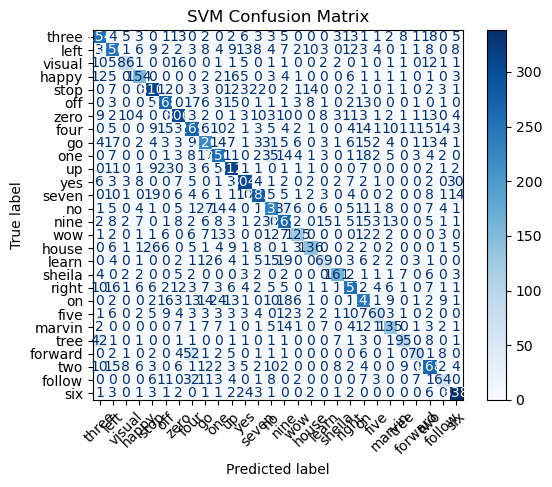

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Assuming you have true labels for your test set in a variable y_test
# y_test is already loaded in the previous code as part of the test dataset

# Display the classification report and accuracy score
print("Classification Report:")
print(classification_report(y_test, y_test_svm))
print("Accuracy Score:", accuracy_score(y_test, y_test_svm))

# Plotting the confusion matrix
def plot_confusion_matrix(y_true, y_pred, label_names, classifier="SVM"):
    confusion_mat = confusion_matrix(y_true, y_pred, labels=label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{classifier} Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

# Define label names based on the unique classes in your dataset
label_names = y_test.unique()  # Automatically infer labels from the test data

# Plot the confusion matrix using the true labels and predictions
plot_confusion_matrix(y_test, y_test_svm, label_names=label_names, classifier="SVM")


In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Paths to train and test data
train_csv = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\training_data.csv'
test_csv = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\test_data.csv'
output_csv = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\Bio_audio_files\predict_rf_final.csv'

# Load features and labels from train data
train_df = pd.read_csv(train_csv).drop(columns=['intensity'], errors='ignore')  # Drop 'intensity' if it exists
test_df = pd.read_csv(test_csv).drop(columns=['intensity'], errors='ignore')

# Extract features and labels
X_train = train_df.drop(columns=['label']).values  # Drop 'label' column to get features
Y_train = train_df['label'].values  # Get labels
X_test = test_df.drop(columns=['label']).values if 'label' in test_df.columns else test_df.values

# Impute missing values with the mean for both train and test sets
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function for cross-validation with Random Forest
def cross_validate(X, y):
    model = RandomForestClassifier(n_estimators=800, random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print("Cross-Validation Scores:", scores)
    print("Mean Cross-Validation Score:", scores.mean())

# Cross-validate
cross_validate(X_train, Y_train)

# Train and predict
rf = RandomForestClassifier(n_estimators=800, random_state=42)
rf.fit(X_train, Y_train)
y_test_rf = rf.predict(X_test)

# Save predictions with IDs if available, else use index
if 'new_id' in test_df.columns:
    test_df['label'] = y_test_rf  # Add predictions
    output_df = test_df[['new_id', 'label']].rename(columns={"new_id": "id"})
else:
    output_df = pd.DataFrame({'id': test_df.index, 'label': y_test_rf})

output_df.to_csv(output_csv, index=False)
print(f"Predictions saved to '{output_csv}'")


c:\Users\PRAVEEN KUMAR\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.60605175 0.59830434 0.60575939 0.5927496  0.58552632]
Mean Cross-Validation Score: 0.5976782787988828
Predictions saved to 'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\Bio_audio_files\predict_rf_final.csv'


Classification Report:
              precision    recall  f1-score   support

        five       0.82      0.09      0.17       149
      follow       0.53      0.26      0.34       160
     forward       0.76      0.34      0.47       158
        four       0.55      0.61      0.58       398
          go       0.57      0.52      0.54       379
       happy       0.67      0.60      0.63       218
       house       0.77      0.47      0.58       220
       learn       0.84      0.20      0.32       156
        left       0.53      0.52      0.53       381
      marvin       0.63      0.49      0.55       212
        nine       0.53      0.69      0.60       410
          no       0.52      0.56      0.54       380
         off       0.62      0.79      0.69       349
          on       0.57      0.51      0.54       390
         one       0.61      0.63      0.62       397
       right       0.62      0.61      0.62       370
       seven       0.66      0.75      0.70       386
    

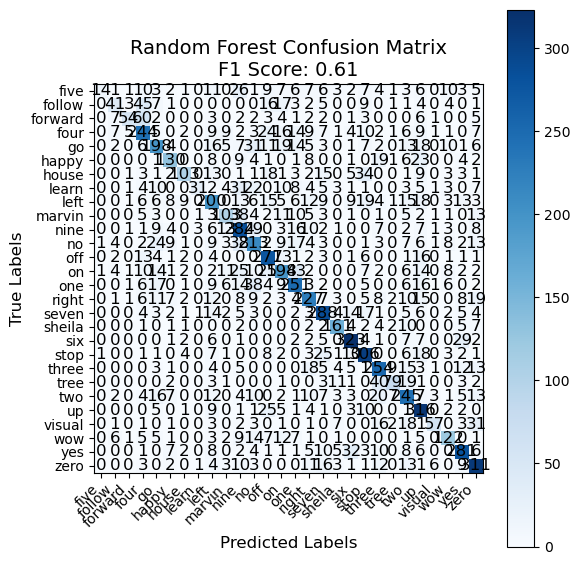

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Define a function to plot the confusion matrix with F1 score in the title
def plot_confusion_matrix_with_f1(y_true, y_pred, label_names, classifier="Random Forest"):
    # Calculate confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred, labels=label_names)
    
    # Calculate the F1 score (weighted) and accuracy score
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    # Display the classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names))
    print(f"Accuracy Score: {accuracy:.4f}")
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
    plt.title(f"{classifier} Confusion Matrix\nF1 Score: {f1:.2f}", fontsize=14)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.xticks(np.arange(len(label_names)), label_names, rotation=45, ha='right')
    plt.yticks(np.arange(len(label_names)), label_names)
    plt.colorbar()

    # Display counts in each cell of the confusion matrix
    for (i, j), label in np.ndenumerate(confusion_mat):
        plt.text(j, i, label, ha='center', va='center', fontsize=12, color="black")
    
    plt.tight_layout()
    plt.show()

# Assuming `y_test` contains the true labels for the test set
# Extract true labels for `label` from the test dataset
y_test = test_df['label'].values  # True labels for the test set

# Plot the confusion matrix with F1 score
unique_labels = np.unique(y_test)  # Automatically detect unique labels in test data
plot_confusion_matrix_with_f1(y_test, y_test_rf, label_names=unique_labels, classifier="Random Forest")


Chi-Square Test
Chi-Square Statistic: 84111.8822
P-value: 0.0000e+00
Degrees of Freedom: 729
Expected Frequencies:
 [[ 0.29622266  1.35913928  1.23716524  7.6843644   6.06385218  3.38042334
   2.33493159  0.64471992  6.62144778  2.8402526   9.39200094  7.16161852
   7.84118817  6.08127704  7.17904339  6.34264998  7.56239036  3.67664601
   7.35329201  7.98058707  7.14419366  1.84703543  7.5449655   9.49655011
   1.28943983  3.32814875  6.847971    8.46848322]
 [ 0.31809145  1.45947842  1.32849959  8.25166647  6.51151912  3.6299848
   2.50730909  0.69231669  7.1102795   3.04993568 10.08537013  7.69032862
   8.42006783  6.53023038  7.70903988  6.81089931  8.12068764  3.94807625
   7.8961525   8.56975792  7.67161735  1.98339376  8.10197638 10.1976377
   1.38463338  3.57385101  7.3535259   9.09367325]
 [ 0.31411531  1.44123494  1.31189335  8.14852064  6.43012513  3.58460999
   2.47596772  0.68366273  7.02140101  3.01181148  9.95930301  7.59419951
   8.31481698  6.4486025   7.61267688  6.725

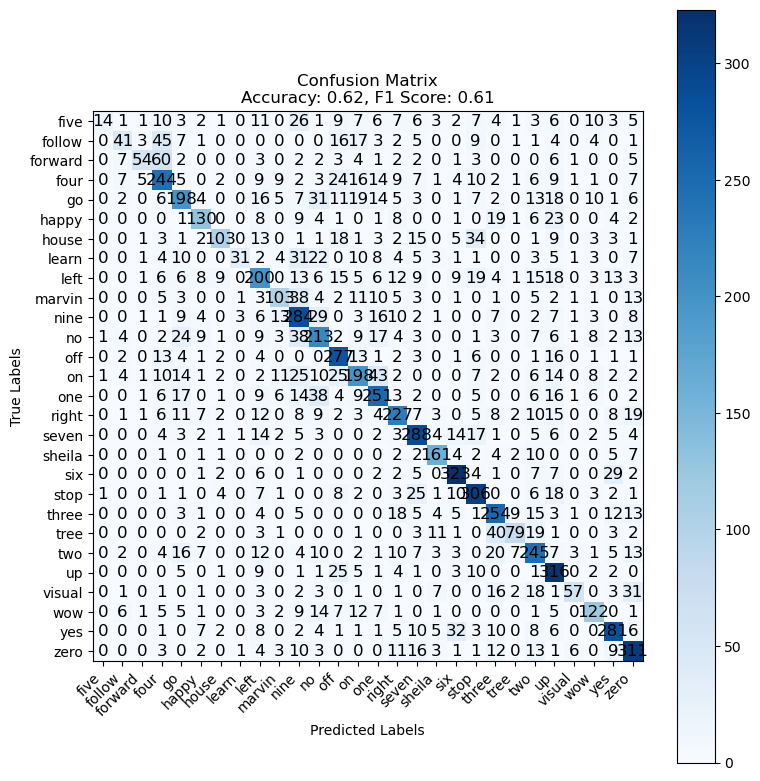

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
from scipy.stats import chi2_contingency, ttest_1samp

# Assuming `y_test` contains true labels and `y_test_rf` contains predicted labels
# True labels (replace with your dataset's actual values)
y_test = test_df['label'].values
y_pred = y_test_rf  # Predicted labels from the Random Forest model

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Chi-Square Test for Independence
chi2, p, dof, expected = chi2_contingency(conf_mat)
print("Chi-Square Test")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p:.4e}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:\n", expected)

# Cohen's Kappa for Agreement
kappa = cohen_kappa_score(y_test, y_pred)
print("\nCohen's Kappa Score")
print(f"Kappa: {kappa:.4f}")

# Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Accuracy")
print(f"Accuracy: {accuracy:.4f}")

# T-Test for Accuracy Significance
# Null hypothesis: Model performs at random guessing level
random_guessing_accuracy = 1 / len(np.unique(y_test))  # Assuming uniform random guessing
t_stat, p_value_ttest = ttest_1samp(y_pred == y_test, random_guessing_accuracy)
print("\nT-Test for Accuracy")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-value: {p_value_ttest:.4e}")

# Detailed Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred))

# Visualize Results
import matplotlib.pyplot as plt

# Confusion Matrix Visualization
def plot_confusion_matrix_with_stats(y_true, y_pred, label_names):
    confusion_mat = confusion_matrix(y_true, y_pred, labels=label_names)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    
    plt.figure(figsize=(8, 8))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation="nearest")
    plt.title(f"Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.colorbar()
    
    # Add numbers in cells
    for (i, j), val in np.ndenumerate(confusion_mat):
        plt.text(j, i, f"{val}", ha="center", va="center", fontsize=12)
    
    plt.xticks(np.arange(len(label_names)), label_names, rotation=45, ha="right")
    plt.yticks(np.arange(len(label_names)), label_names)
    plt.tight_layout()
    plt.show()

# Get unique labels
label_names = np.unique(y_test)

# Plot confusion matrix with stats
plot_confusion_matrix_with_stats(y_test, y_pred, label_names=label_names)


After denoising

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.signal import butter, lfilter

# Butterworth Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.1, highcut=30.0, fs=16000, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data, axis=0)

# Load the train and test CSV files with extracted features
train_df = pd.read_csv(r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\training_data.csv')
test_df = pd.read_csv(r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\test_data.csv')

# Drop the 'intensity' column if it exists
if 'intensity' in train_df.columns:
    train_df = train_df.drop(columns=['intensity'])

if 'intensity' in test_df.columns:
    test_df = test_df.drop(columns=['intensity'])

# Separate features and labels, assuming 'label' is the target label
if 'label' in train_df.columns:
    y_train = train_df['label'].reset_index(drop=True)
    train_features = train_df.drop(columns=['label']).reset_index(drop=True)
else:
    train_features = train_df.reset_index(drop=True)

if 'label' in test_df.columns:
    y_test = test_df['label'].reset_index(drop=True)
    test_features = test_df.drop(columns=['label']).reset_index(drop=True)
else:
    test_features = test_df.reset_index(drop=True)

# Debug: Check Initial Feature Stats
print("Initial train features statistics:")
print(train_features.describe())

# Apply denoising using Butterworth bandpass filter
train_features = pd.DataFrame(bandpass_filter(train_features.values), columns=train_features.columns)
test_features = pd.DataFrame(bandpass_filter(test_features.values), columns=test_features.columns)

# Replace infinite values and cap extreme values
train_features.replace([np.inf, -np.inf], np.nan, inplace=True)
test_features.replace([np.inf, -np.inf], np.nan, inplace=True)
max_value = 1e3  # Stricter cap for outliers
train_features = train_features.clip(lower=-max_value, upper=max_value)
test_features = test_features.clip(lower=-max_value, upper=max_value)

# Debug: Check Feature Stats After Capping
print("Train features statistics after capping:")
print(train_features.describe())

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
train_features = pd.DataFrame(imputer.fit_transform(train_features), columns=train_features.columns)
test_features = pd.DataFrame(imputer.transform(test_features), columns=test_features.columns)

# Standardize the features
scaler = StandardScaler(with_mean=False)
try:
    train_features = pd.DataFrame(scaler.fit_transform(train_features), columns=train_features.columns)
    test_features = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)
except Exception as e:
    print(f"Error during scaling: {e}")

# Replace any NaN values after scaling
train_features = train_features.fillna(0)
test_features = test_features.fillna(0)

# Debug: Check NaN Count After Scaling
print("NaN values in train features after scaling:", np.isnan(train_features).sum().sum())
print("NaN values in test features after scaling:", np.isnan(test_features).sum().sum())

# Apply PCA to retain 95% of the explained variance
pca = PCA(n_components=0.95)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

# Convert PCA-transformed features back to DataFrame
train_features_pca_df = pd.DataFrame(train_features_pca)
test_features_pca_df = pd.DataFrame(test_features_pca)

# Add 'label' back to the transformed data if it was present
if 'label' in train_df.columns:
    train_features_pca_df['label'] = y_train
if 'label' in test_df.columns:
    test_features_pca_df['label'] = y_test

# Save PCA-transformed data back to CSV
train_features_pca_df.to_csv(r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\train_pca.csv', index=False)
test_features_pca_df.to_csv(r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\test_pca.csv', index=False)

print("Denoising and PCA transformation complete.")
print("Training features shape after PCA:", train_features_pca_df.shape)
print("Testing features shape after PCA:", test_features_pca_df.shape)
print("Explained variance by selected components:", np.sum(pca.explained_variance_ratio_))


Initial train features statistics:
        mfcc_mean_0   mfcc_mean_1   mfcc_mean_2   mfcc_mean_3   mfcc_mean_4  \
count  34204.000000  34204.000000  34204.000000  34204.000000  34204.000000   
mean    -599.384254     72.463324     -1.965985     14.268222     -3.000503   
std       89.355227     33.373814     19.523923     15.545768     12.746638   
min     -923.359192    -92.638641   -112.181816    -76.974098    -66.062325   
25%     -655.764893     51.144310    -14.203948      3.985559    -11.142869   
50%     -601.485565     73.433033     -1.410487     14.275633     -2.830838   
75%     -545.813797     95.283066     10.902356     24.510193      5.410090   
max     -144.806137    196.900009     80.322868     92.810074     55.289059   

        mfcc_mean_5   mfcc_mean_6   mfcc_mean_7   mfcc_mean_8   mfcc_mean_9  \
count  34204.000000  34204.000000  34204.000000  34204.000000  34204.000000   
mean       4.658294     -3.978316     -0.798649     -6.002878     -1.792789   
std       11.043

In [10]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Helper Function: Replace NaN and Inf, Clip Values
def preprocess_features(features, clip_min=-1e5, clip_max=1e5):
    """Preprocess features by replacing NaNs and infinities and clipping values."""
    features = np.nan_to_num(features, nan=0.0, posinf=clip_max, neginf=clip_min)
    features = np.clip(features, clip_min, clip_max)
    return features

# Paths to denoised and PCA-transformed train and test data
train_csv_path = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\train_pca.csv'
test_csv_path = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\test_pca.csv'
output_predictions_path = r'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\predict_svm.csv'

# Load PCA-transformed train and test data
X_train = pd.read_csv(train_csv_path)
X_test = pd.read_csv(test_csv_path)

# Separate target labels from features
if 'label' in X_train.columns:
    Y_train = X_train['label']
    X_train = X_train.drop(columns=['label'], errors='ignore')
if 'label' in X_test.columns:
    X_test = X_test.drop(columns=['label'], errors='ignore')

# Preprocess the features
X_train_preprocessed = preprocess_features(X_train.values)
X_test_preprocessed = preprocess_features(X_test.values)

# Ensure data is scaled
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_preprocessed)
X_test_scaled = scaler.transform(X_test_preprocessed)

# SVM Classifier
def cross_validate(X_train, Y_train):
    model = SVC()
    scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')
    print(f"Cross-Validation Scores (SVM): {scores}")
    print(f"Mean Cross-Validation Score (SVM): {scores.mean()}")

def svm_classifier(X_train, Y_train, X_test):
    svm = SVC()
    svm.fit(X_train, Y_train)
    return svm.predict(X_test)

# Perform cross-validation
cross_validate(X_train_scaled, Y_train)

# Classify PCA test features using the SVM classifier
y_test_svm = svm_classifier(X_train_scaled, Y_train, X_test_scaled)

# Save predictions
test_df = pd.DataFrame(X_test_scaled)  # Initialize with X_test to get correct row count
test_df['label'] = y_test_svm  # Add predictions
test_df.to_csv(output_predictions_path, index=False)

print(f"Predictions saved to '{output_predictions_path}'")


c:\Users\PRAVEEN KUMAR\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores (SVM): [0.04092969 0.04166058 0.03215904 0.04166058 0.04561404]
Mean Cross-Validation Score (SVM): 0.04040478333679543
Predictions saved to 'C:\Users\PRAVEEN KUMAR\Desktop\BioMedical\predict_svm.csv'


Classification Report:


c:\Users\PRAVEEN KUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PRAVEEN KUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PRAVEEN KUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        five       0.00      0.00      0.00       149
      follow       0.00      0.00      0.00       160
     forward       0.00      0.00      0.00       158
        four       0.05      0.00      0.00       398
          go       0.05      0.01      0.01       379
       happy       0.00      0.00      0.00       218
       house       0.00      0.00      0.00       220
       learn       0.00      0.00      0.00       156
        left       0.08      0.01      0.01       381
      marvin       0.00      0.00      0.00       212
        nine       0.07      0.04      0.05       410
          no       0.05      0.20      0.08       380
         off       0.04      0.08      0.05       349
          on       0.05      0.01      0.01       390
         one       0.25      0.00      0.00       397
       right       0.00      0.00      0.00       370
       seven       0.00      0.00      0.00       386
      sheila       0.00    

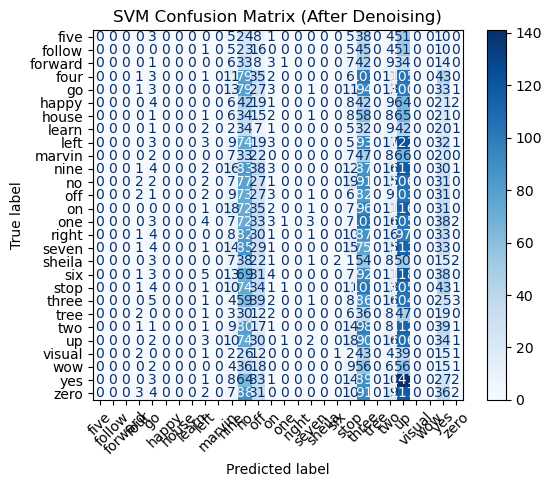

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Display the classification report and accuracy score
print("Classification Report:")
print(classification_report(y_test, y_test_svm))
print("Accuracy Score:", accuracy_score(y_test, y_test_svm))

# Plotting the confusion matrix
def plot_confusion_matrix(y_true, y_pred, label_names, classifier="SVM"):
    confusion_mat = confusion_matrix(y_true, y_pred, labels=label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{classifier} Confusion Matrix (After Denoising)")
    plt.xticks(rotation=45)
    plt.show()

# Define label names based on the unique classes in your dataset
label_names = sorted(y_test.unique())  # Automatically infer labels from the test data

# Plot the confusion matrix using the true labels and predictions
plot_confusion_matrix(y_test, y_test_svm, label_names=label_names, classifier="SVM")
